## Convolution Neural Network using Pytorch and MLFLow for tracking

### Import Libraries

In [1]:
#import pytorch libraries
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.optim as optim
from torch.autograd import Variable

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import os

print(f" Libraries imported, ready to use.\n Pytorch version: {torch.__version__}")

 Libraries imported, ready to use.
 Pytorch version: 2.0.1


### MLFLow tracking

In [2]:
import mlflow
from mlflow.models import infer_signature

In [3]:
mlflow.set_tracking_uri("http://127.0.0.1:8080")

In [4]:
shapes_experiment = mlflow.set_experiment('Shapes_Model')
# define a name for this iteration of training , 
# if this is not set , a unique name will be autogenerated for the run
run_name = 'cnn_model_1'

# define the artifact path that the model be saved to
artifact_path = 'cnn_shapes'

### Explore Data

In [5]:
data_path = 'C:\\Users\\nishant\\Downloads\\azure-dp-100\\dataset\\shapes\\shapes'

#get the class names
classes = os.listdir(data_path)
classes.sort()

print(len(classes) ," classes are : ", classes)

4  classes are :  ['circle', 'square', 'star', 'triangle']


0.png
C:\Users\nishant\Downloads\azure-dp-100\dataset\shapes\shapes\circle\0.png
0.png
C:\Users\nishant\Downloads\azure-dp-100\dataset\shapes\shapes\square\0.png
0.png
C:\Users\nishant\Downloads\azure-dp-100\dataset\shapes\shapes\star\0.png
0.png
C:\Users\nishant\Downloads\azure-dp-100\dataset\shapes\shapes\triangle\0.png


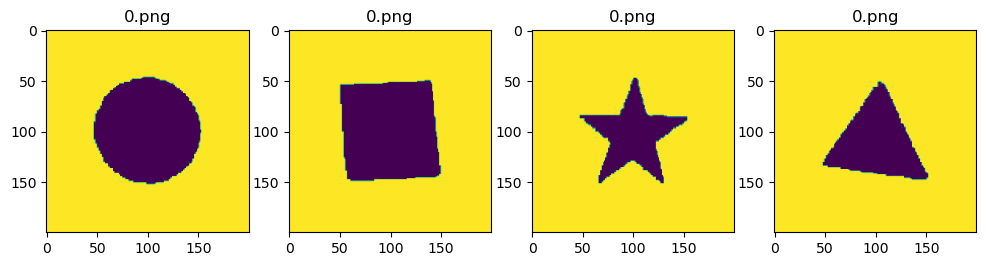

In [6]:
#show the first image in each folder
fig = plt.figure(figsize=(12,6))

i =0
for sub_dir in os.listdir(data_path):
    i += 1
    img_file = os.listdir(os.path.join(data_path, sub_dir))[0]
    print(img_file)
    image_path = os.path.join(data_path, sub_dir,img_file)
    print(image_path)
    img = mpimg.imread(image_path)
    a = fig.add_subplot(1,len(classes), i)
    
#     a.axis('off')
    imgplot = plt.imshow(img)
    a.set_title(img_file)
plt.show()

### Load Data

PyTorch includes functions for loading and transforming data. We'll use these to create an iterative loader for training data, and a second iterative loader for test data (which we'll use to validate the trained model). The loaders will transform the image data into *tensors*, which are the core data structure used in PyTorch, and normalize them so that the pixel values are in a scale with a mean of 0.5 and a standard deviation of 0.5.

In [7]:
#function to ingest data using training and  test loaders

def load_dataset(data_path):
    # load the images
    transformations = transforms.Compose([
        # to tensor
        transforms.ToTensor(),
        # nornalize the pixel value
        transforms.Normalize(mean = [0.5,0.5,0.5], std = [0.5 ,0.5, 0.5])
    ])
    
    # load the images transforming them
    full_dataset = torchvision.datasets.ImageFolder(
        root = data_path,
        transform = transformations
    )
    
    
    # split the dataset into training and test set
    train_size = int(0.7 * len(full_dataset))
    test_size = len(full_dataset) - train_size
    
    train_dataset , test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])
    
    # define a loader for the training data we can iterate through in 50 image batches
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size = 50,
        num_workers = 0,
        shuffle = False
    )
    
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size = 50,
        num_workers = 0,
        shuffle = True
    )
    
    return train_loader, test_loader


# get the iterative dataloaders for train and test datasets
train_loader, test_loader = load_dataset(data_path)
print(" length of train data loader: ", len(train_loader))
print("\n length of test data loader: ", len(test_loader))

 length of train data loader:  210

 length of test data loader:  90


### Define the CNN

In PyTorch, we define a neural network model as a class that is derived from the **nn.Module** base class

In [8]:
# create a neural net class
class ConvNet(nn.Module):
    
    def __init__(self, num_classes):
        super(ConvNet, self).__init__()
        # define the conv2d layer
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 12, kernel_size = 3,stride = 1, padding = 1)
        
        # pooling layer
        self.pool = nn.MaxPool2d(kernel_size = 2)
        
        # second convolution layer
        self.conv2 = nn.Conv2d(in_channels = 12, out_channels = 12, kernel_size = 3, stride = 1, padding = 1)
        
        
        # third convolution layer
        self.conv3 = nn.Conv2d(in_channels = 12, out_channels = 24, kernel_size = 3, stride = 1, padding = 1)
        
        # dropout layer
        self.drop = nn.Dropout2d(p=0.2)
        
        # fully connected layers
        # 200 x 200 pooled twice - 200/2/2 = 50
        self.fc1 = nn.Linear(in_features = 50 * 50 * 24, out_features = 100)
        
        self.fc2 = nn.Linear(in_features = 100, out_features = 80)
        
        self.fc3 = nn.Linear(in_features = 80, out_features = num_classes)
        
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(x)
        x = F.relu(x)
        
        x = F.relu(self.pool(self.conv2(x)))
        
        x = F.relu(self.drop(self.conv3(x)))
        
        #only drop the feature if training pass
        x = F.dropout(x , training = self.training)
        
        # flatten
#         print("lets see the shape here:",x.shape)
        x = x.view(-1, 50 *50* 24)
        # feed the fully connected to with the data
        x = self.fc1(x)
        # train the layer to predict class
        x = self.fc2(x)
        
        x = self.fc3(x)
        
        return F.log_softmax(x, dim = 1)
    
print("CNN model defined")
        
        
        

CNN model defined


### Train the model

Now that we've defined a class for the network, we can train it using the image data.

In [9]:
def train(model, device, train_loader, optimizer, epoch):
    # set model to training mode
    model.train()
    
    train_loss = 0
    
    print("Epoch:", epoch)
    
    #process the images in batches
    for batch_idx, (data, target) in enumerate(train_loader):
        #use gpu if available
        data, target = data.to(device), target.to(device)
        print("Shape of the data:", data.shape)
        #reset the optimizer
        optimizer.zero_grad()
        
        output = model(data)
        
        # get the loss 
        loss = loss_criteria(output, target)
        
        # keep a running total
        train_loss += loss.item()
        
        #backpropogate
        loss.backward()
        optimizer.step()
        
        # print metrics for every 10 batches
        if batch_idx % 10 == 0:
            print("Training set [{}/{} ({:.0f} %)] Loss : {:.6f}".format(batch_idx * len(data), len(train_loader.dataset), 
                                                                      100. * batch_idx * len(train_loader), 
                                                                      loss.item()))
            
        # return average loss for the epoch
        avg_loss = train_loss / (batch_idx + 1)
        
        print("Training Set: Average Loss: {:.6f}".format(avg_loss))
        
        return avg_loss
    
    
def test(model, device, test_loader):
    model.eval()
    
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        batch_count = 0
        for data, target in test_loader:
            batch_count += 1
            data, target = data.to(device), target.to(device)
            
            # get the predicted class
            output = model(data)
            
            # calculate the loss
            test_loss += loss_criteria(output, target).item()
            
            #calculate accuracy for the batch
            _, predicted = torch.max(output.data , 1)
            
            correct += torch.sum(target==predicted).item()
            
    # calculate the average loss and total accuracy
    avg_loss = test_loss/ batch_count
    
    print("Validation Set: Average loss :{:.6f}, Accuracy:{}/{} ({:.0f}%)\n".format(
        avg_loss, correct, len(test_loader.dataset),
        100. * correct/ len(test_loader.dataset)
    ))
    return avg_loss


#use the train and test functions to train and test the data

if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
    
print(f'Training on :{device}')


# create an instance of the model
cnn_model = ConvNet(num_classes= len(classes)).to(device)

#optimizer
learning_rate = 0.001
optimizer = optim.Adam(cnn_model.parameters(), lr = learning_rate)

# loss
loss_criteria = nn.CrossEntropyLoss()


# track the metrics

epoch_nums = []
training_loss = []
validation_loss = []


# train over 10 epochs for trial
epochs = 20
for epoch in range(1, epochs + 1):
    train_loss = train(cnn_model, device, train_loader, optimizer, epoch )
    test_loss = test(cnn_model, device, test_loader)
    
    epoch_nums.append(epoch)
    training_loss.append(train_loss)
    validation_loss.append(test_loss)            

Training on :cuda
Epoch: 1
Shape of the data: torch.Size([50, 3, 200, 200])
Training set [0/10479 (0 %)] Loss : 1.386658
Training Set: Average Loss: 1.386658
Validation Set: Average loss :1.596111, Accuracy:1106/4491 (25%)

Epoch: 2
Shape of the data: torch.Size([50, 3, 200, 200])
Training set [0/10479 (0 %)] Loss : 1.481377
Training Set: Average Loss: 1.481377
Validation Set: Average loss :1.261605, Accuracy:1850/4491 (41%)

Epoch: 3
Shape of the data: torch.Size([50, 3, 200, 200])
Training set [0/10479 (0 %)] Loss : 1.247102
Training Set: Average Loss: 1.247102
Validation Set: Average loss :1.171894, Accuracy:2247/4491 (50%)

Epoch: 4
Shape of the data: torch.Size([50, 3, 200, 200])
Training set [0/10479 (0 %)] Loss : 1.146195
Training Set: Average Loss: 1.146195
Validation Set: Average loss :1.088970, Accuracy:2249/4491 (50%)

Epoch: 5
Shape of the data: torch.Size([50, 3, 200, 200])
Training set [0/10479 (0 %)] Loss : 1.023673
Training Set: Average Loss: 1.023673
Validation Set: Av

### View the Metrics

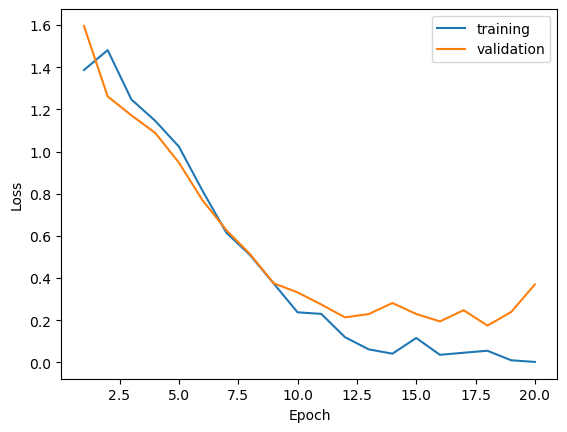

In [10]:
plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)

plt.xlabel("Epoch")
plt.ylabel('Loss')
plt.legend(['training', 'validation'], loc = 'upper right')
plt.show()

### Evaluate performance

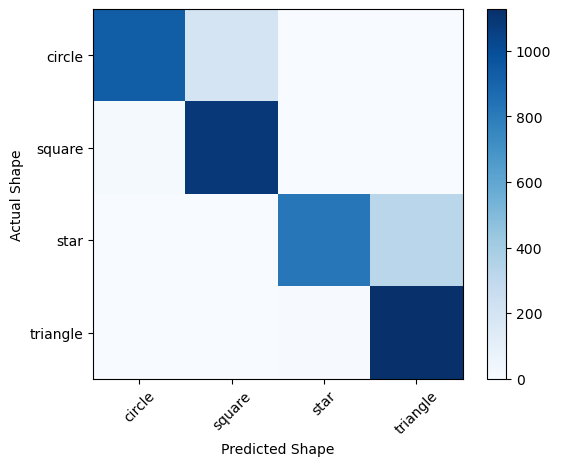

In [11]:
from sklearn.metrics import confusion_matrix
# import seaborn as sns



# set the model to evaluate mode
cnn_model.eval()


# get the prediction for test data and convert to numpy array for use with sckikit learn

true_labels = []
predictions = []

for data, target in test_loader:
    for label in target.cpu().data.numpy():
        true_labels.append(label)
    for prediction in cnn_model.cpu()(data).data.numpy().argmax(1):
        predictions.append(prediction)
        

# plot confusion matrix
cm = confusion_matrix(true_labels, predictions)
# sns.heatmap(cm, cmap='crest')
plt.imshow(cm, interpolation = 'nearest', cmap = plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Shape')
plt.ylabel('Actual Shape')
plt.show()


### Save the trained model

In [12]:
model_file = 'models\\shape_classifier.pt'
torch.save(cnn_model.state_dict(),model_file)

# del cnn_model
print('Model saved as : ', model_file)


Model saved as :  models\shape_classifier.pt


In [13]:
os.getcwd()

'C:\\Users\\nishant'

### Use the trained model

In [14]:
import matplotlib.pyplot as plt
import os
from random import randint
%matplotlib inline

# function to predict the class of an image
def predict_image(classifier, image):
    import numpy
    
    # set to eval mode
    classifier.eval()
    
    # apply the same transformation as done while training
    transformation = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.5,0.5,0.5], std = [0.5,0.5,0.5])
        
    ])
    
    # preprocess the image
    image_tensor = transformation(image).float()
    
    # convert to batches, add batch dimension
    image_tensor = image_tensor.unsqueeze_(0)
    
    # turn the input into a variable
    input_features = Variable(image_tensor)
    
    # predict the class
    output = classifier(input_features)
    index = output.data.numpy().argmax()
    return index



# function to create a random image
def create_image(size, shape):
    from random import randint
    import numpy as np
    from PIL import Image, ImageDraw
    
    xy1 = randint(10,40)
    xy2 = randint(60,100)
    col = (randint(0,200), randint(0,200), randint(0,200))
    
    img = Image.new("RGB", size , (255,255,255))
    draw = ImageDraw.Draw(img)
    
    if shape =='circle':
        draw.ellipse([(xy1,xy1),(xy2,xy2)],fill=col)
    elif shape=='traingle':
        draw.polygon([(xy1,xy1),(xy2,xy2),(xy2,xy1)], fill=col)
    elif shape =='square':
        draw.rectangle([(xy1,xy1),(xy2,xy2)], fill = col)        
        
#     del draw
    
    return np.array(img)
        

triangle


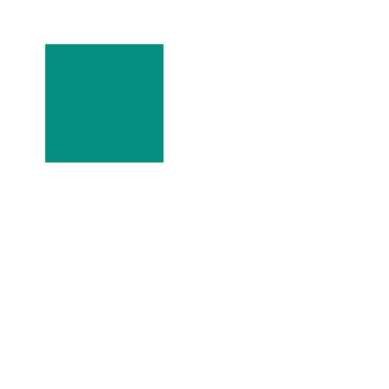

In [15]:

# create a random test image
# classnames = os.listdir(os.path.join('data', 'shapes'))
classnames = os.listdir(data_path)
classnames.sort()
shape = classnames[randint(0, len(classnames) - 1)]
img = create_image((200,200), shape)

# display the image
plt.axis('off')
plt.imshow(img)

# create model class and load the saved weights
model = ConvNet(4)
model.load_state_dict(torch.load(model_file))

# call prediction
index = predict_image(model, img)
print(classes[index])


In [16]:
# Initiate the mlflow run context

with mlflow.start_run(run_name= run_name) as run:
    # log the parameter used for model fit
    params = {'learning_rate' : learning_rate, 'optimizer' : optimizer,
             'epochs': epoch_nums, 
             'training_loss': training_loss, 'validation_loss': validation_loss}
    mlflow.log_params( params)
    signature = infer_signature(img,classes[index])
    
    # log an instance of the model for later use
    mlflow.pytorch.log_model(cnn_model, "model", conda_env = mlflow.pytorch.get_default_conda_env(), signature = signature)
    
    env = mlflow.pytorch.get_default_conda_env()
    print(f"conda env: {env}")

2023/11/04 22:48:52 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh()

All git commands will error until this is rectified.

This initial warning can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|none|n|0: for no warning or exception
    - warn|w|warning|1: for a printed warning
    - error|e|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet

C:\Users\nishant\anaconda3\envs\pytlearning\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


conda env: {'name': 'mlflow-env', 'channels': ['conda-forge'], 'dependencies': ['python=3.9.0', 'pip<=23.2.1', {'pip': ['mlflow', 'torch==2.0.1', 'cloudpickle==2.2.1']}]}
